In [78]:
import os

import numpy as np
import pandas as pd
import dask.dataframe as dd

from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint, MultiLineString
from shapely.ops import linemerge, nearest_points

import geopandas as gpd
from geopandas import GeoDataFrame
from centerline.geometry import Centerline

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

## Get Sidewalk Centerlines

In [79]:
df = gpd.read_file('../data/toronto_example.shp')

In [80]:
crs = {'init': 'epsg:26917'}
df.crs = crs

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


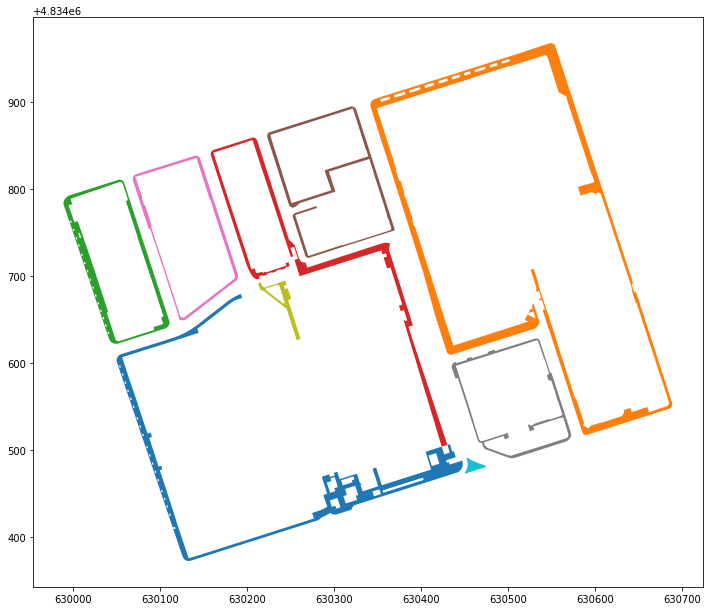

In [81]:
df.plot(figsize=(12, 12), cmap='tab10')

In [82]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))

In [83]:
df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode())

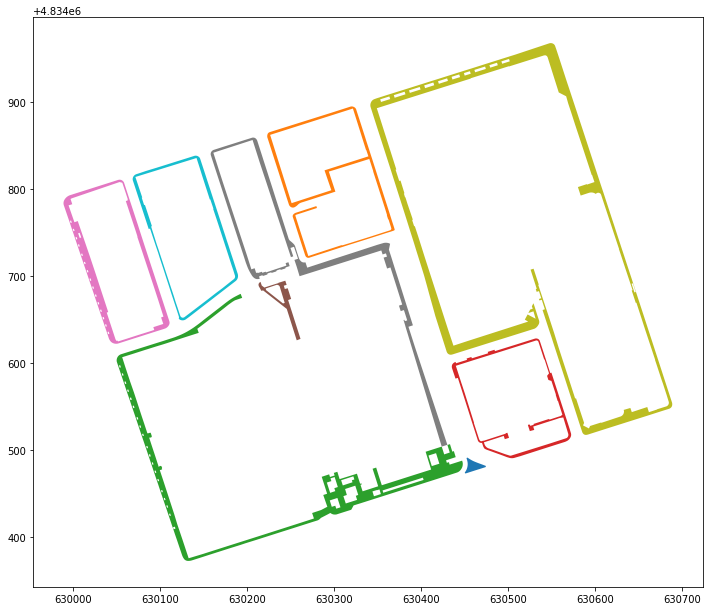

In [84]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [85]:
# In a dataset of 14k objects, deriving the centerline failed on 9 objects. Not sure why. 
# Added "GetCenterlineSafely" to bypass those failures and keep running.

In [86]:
def getCenterlineSafely(row):
    try:
        return Centerline(row.geometry)
    except:
        return None

In [87]:
df_exploded['centerlines'] = df_exploded.progress_apply(lambda row: getCenterlineSafely(row), axis=1)

In [88]:
df_exploded = df_exploded.set_geometry('centerlines')

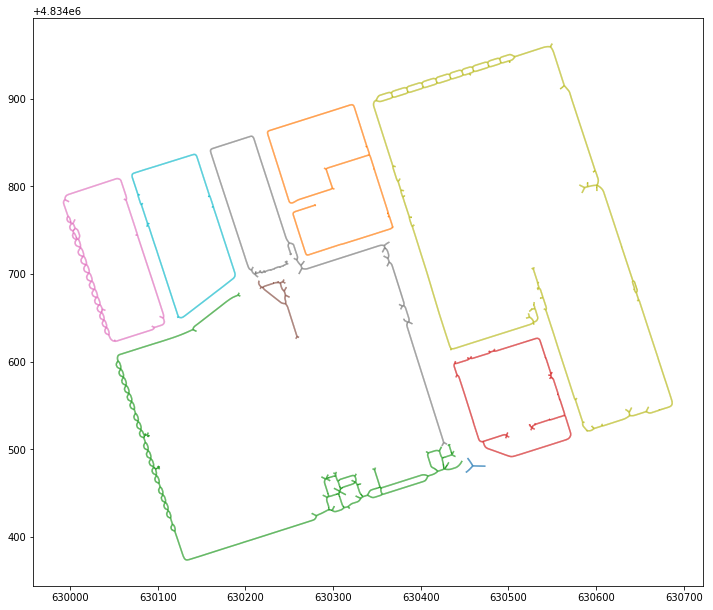

In [89]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

## Remove Short Line Ends

In [90]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(linemerge)

In [91]:
def remove_short_lines(line):
    
    if line.type == 'MultiLineString':
        
        passing_lines = []
    
        for i, linestring in enumerate(line):
            
            other_lines = MultiLineString([x for j, x in enumerate(line) if j != i])
            
            p0 = Point(linestring.coords[0])
            p1 = Point(linestring.coords[-1])
            
            is_deadend = False
            
            if p0.disjoint(other_lines): is_deadend = True
            if p1.disjoint(other_lines): is_deadend = True
            
            if not is_deadend or linestring.length > 5:                
                passing_lines.append(linestring)
            
        return MultiLineString(passing_lines)
            
    if line.type == 'LineString':
        return line

In [92]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(remove_short_lines)

In [93]:
df_exploded.head()

,,geometry,centerlines
0,0,"POLYGON ((630453.418 4834490.940, 630453.502 4...","MULTILINESTRING ((630451.358 4834473.695, 6304..."
1,0,"POLYGON ((630324.981 4834892.247, 630325.091 4...","MULTILINESTRING ((630279.146 4834778.533, 6302..."
2,0,"POLYGON ((630056.759 4834606.339, 630059.693 4...","MULTILINESTRING ((630139.973 4834636.704, 6301..."
3,0,"POLYGON ((630536.253 4834625.723, 630536.355 4...","MULTILINESTRING ((630438.757 4834598.051, 6304..."
4,0,"POLYGON ((630245.712 4834689.481, 630242.441 4...","MULTILINESTRING ((630215.563 4834692.429, 6302..."


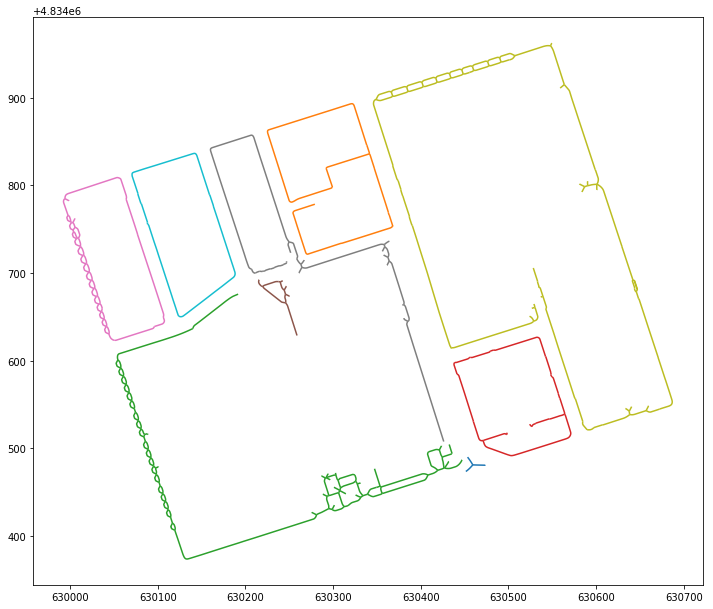

In [94]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

## Get Sidewalk Widths

In [95]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(lambda row: row.simplify(1, preserve_topology=True))

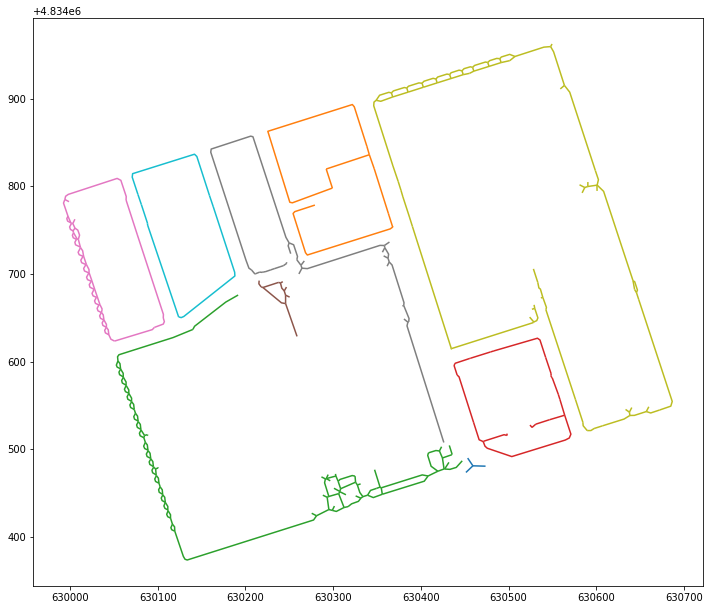

In [96]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [97]:
def linestring_to_segments(linestring):
    return [LineString([linestring.coords[i], linestring.coords[i+1]]) for i in range(len(linestring.coords) - 1)]

In [98]:
def get_segments(line):
    
    line_segments = []

    if line.type == 'MultiLineString':
        
        for linestring in line.geoms:
            
            line_segments.extend(linestring_to_segments(linestring))

    if line.type == 'LineString':
        
        line_segments.extend(linestring_to_segments(line))

    return line_segments

In [99]:
df_exploded.head(1)

,,geometry,centerlines
0,0,"POLYGON ((630453.418 4834490.940, 630453.502 4...","MULTILINESTRING ((630451.358 4834473.695, 6304..."


In [100]:
df_exploded['segments'] = df_exploded['centerlines'].progress_apply(get_segments)
df_exploded.head(1)

,,geometry,centerlines,segments
0,0,"POLYGON ((630453.418 4834490.940, 630453.502 4...","MULTILINESTRING ((630451.358 4834473.695, 6304...",[LINESTRING (630451.3576119036 4834473.6948888...


In [101]:
def interpolate_by_distance(linestring):
    
    distance = 1
    all_points = []
    count = round(linestring.length / distance) + 1
    
    if count == 1:
        all_points.append(linestring.interpolate(linestring.length / 2))
    
    else:
        for i in range(count):
            all_points.append(linestring.interpolate(distance * i))
    
    return all_points

def interpolate(line):
    
    if line.type == 'MultiLineString':
        
        all_points = []
        
        for linestring in line:
            all_points.extend(interpolate_by_distance(linestring))
        
        return MultiPoint(all_points)
            
    if line.type == 'LineString':
        return MultiPoint(interpolate_by_distance(line))
    
    
def polygon_to_multilinestring(polygon):

    return MultiLineString([polygon.exterior] + [line for line in polygon.interiors])
    

def get_avg_distances(row):
    
    avg_distances = []
    
    sidewalk_lines = polygon_to_multilinestring(row.geometry)
    
    for segment in row.segments:
        
        points = interpolate(segment)
        
        distances = []
        
        for point in points:
            p1, p2 = nearest_points(sidewalk_lines, point)
            distances.append(p1.distance(p2))
            
        avg_distances.append(sum(distances) / len(distances))
        
    return avg_distances

In [102]:
df_exploded['avg_distances'] = df_exploded.progress_apply(lambda row: get_avg_distances(row), axis=1)
df_exploded.head(1)

,,geometry,centerlines,segments,avg_distances
0,0,"POLYGON ((630453.418 4834490.940, 630453.502 4...","MULTILINESTRING ((630451.358 4834473.695, 6304...",[LINESTRING (630451.3576119036 4834473.6948888...,"[2.8765925884000403, 2.9940955631913515, 3.170..."


In [103]:
data = {'geometry': [], 'width': []}

for i, row in df_exploded.iterrows():
    
    for segment in row.segments:
        data['geometry'].append(segment)
    
    for distance in row.avg_distances:
        data['width'].append(distance * 2)
        
df_segments = pd.DataFrame(data)
df_segments = GeoDataFrame(df_segments, crs=crs, geometry='geometry')
df_segments.head(1)

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry,width
0,"LINESTRING (630451.358 4834473.695, 630459.284...",5.753185


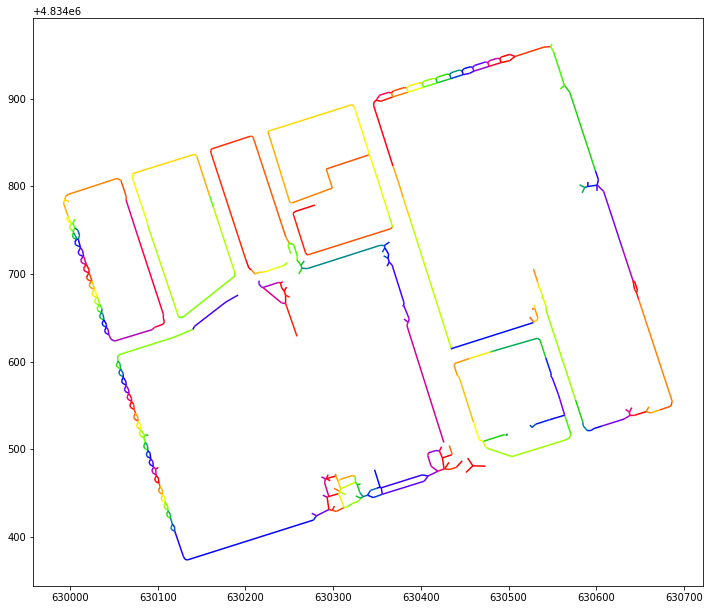

In [104]:
df_segments.plot(figsize=(12, 12), cmap='prism')

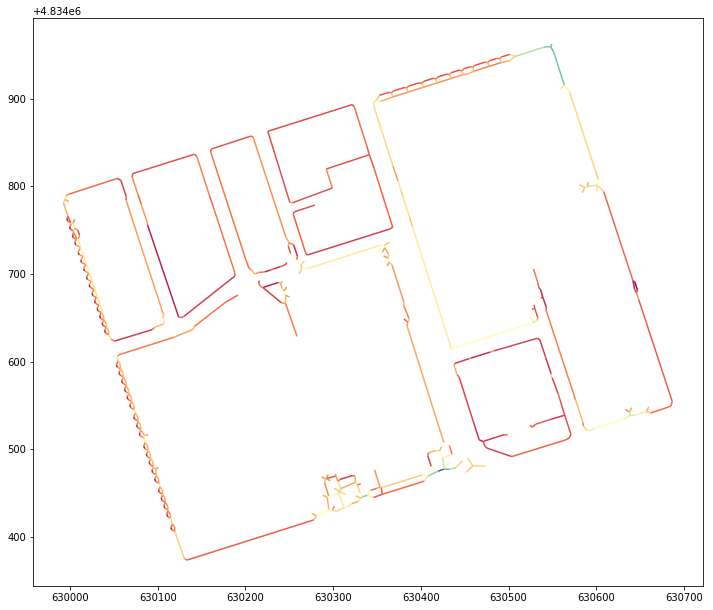

In [105]:
df_segments.plot(figsize=(12, 12), column='width', cmap='Spectral')

In [106]:
df_segments['width'] = df_segments['width'] * 3.28084

In [107]:
df_segments['width'] = round(df_segments['width'] * 10) / 10
df_segments.head()

,geometry,width
0,"LINESTRING (630451.358 4834473.695, 630459.284...",18.9
1,"LINESTRING (630453.335 4834490.070, 630459.284...",19.6
2,"LINESTRING (630473.708 4834480.836, 630459.284...",20.8
3,"LINESTRING (630279.146 4834778.533, 630256.168...",7.4
4,"LINESTRING (630256.168 4834771.053, 630254.269...",7.4


In [108]:
df_segments.crs

<Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 84°W to 78°W and NAD83 by country
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [109]:
df_projected = df_segments.to_crs('EPSG:4326')
df_projected.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [110]:
with open('toront_example_output.geojson', 'w') as f:
    f.write(df_projected.to_json())